In [522]:
import math

class Node:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data= data
        self._op = _op
        self.label = label

        self.grad = 0.0

        self._prev = _children


    def __repr__(self):
        return f"Node(data={self.data})" #, children={self._prev})"
    
    def __add__(self, other):
        out = Node(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Node(self.data * other.data, (self, other), '*')
        return out
    
    def __sub__(self, other):
        out = Node(self.data - other.data, (self, other), '-')
        return out
    
    def __pow__(self, other):
        out = Node(self.data**other.data, (self, other), '**')
        return out

    def __iadd__(self, other):
        total = self.data + other.data
        out = Node(total, (self, other), '+')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Node(t, (self, ), 'TanH')
        return out
    
    def RelU(self):
        x = self.data
        r = max(0, x)
        out = Node(r, (self, ), 'RelU')
        return out
    
    def backward(self):
        self.grad = 1
        def recurse(node):
            if not node._prev:
                return
            
            if node._op == '+':
                for n in node._prev:
                    n.grad += 1.0 * node.grad
                    recurse(n)

            if node._op == '-':
                node._prev[0].grad += 1.0 * node.grad
                recurse(node._prev[0])
                node._prev[1].grad += -1.0 * node.grad
                recurse(node._prev[1])

            if node._op == '*':
                node._prev[0].grad += node._prev[1].data * node.grad
                recurse(node._prev[0])
                node._prev[1].grad += node._prev[0].data * node.grad
                recurse(node._prev[1])
            
            if node._op == '**':
                exp = node._prev[1].data
                node._prev[0].grad += exp * (node._prev[0].data ** (exp - 1)) * node.grad
                recurse(node._prev[0])
                # recurse(node._prev[1])

            if node._op == 'TanH':
                node._prev[0].grad += (1 - node.data**2) * node.grad
                recurse(node._prev[0])

            if node._op == 'RelU':
                if node.data > 0:
                    node._prev[0].grad += 1 * node.grad
                else:
                    node._prev[0].grad += 0
                recurse(node._prev[0])
            
                
        recurse(self)

# calculate_gradients(L)

a = Node(2.0, label='a')
b = Node(-3.0, label='b')
c = Node(10.0, label='c')

e = a*b; e.label='e'
d = e + c; d.label='d'
f = Node(-2.0, label='f')
L = d*f; L.label='L'
d

Node(data=4.0)

In [523]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label= "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
    

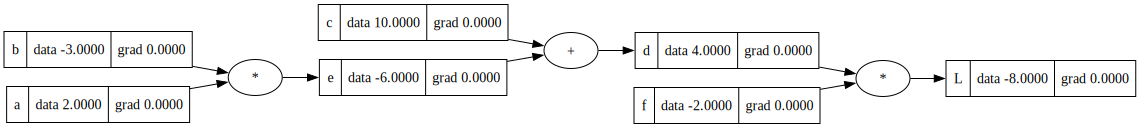

In [524]:
draw_dot(L)

In [525]:
# L = d * f

# dL/dd = ?f

# dL / dc 

# d = c + e

#  dL / dc = (dL/dd) * (dd/dc)

# DL / de = -2

# dL/da = DL/de * de/da



In [526]:
e = a*b; e.label='e'
d = e + c; d.label='d'
L = d*f; L.label='L'

In [527]:
def calculate_gradients(root):
    root.grad = 1
    def recurse(node):
        if node._prev == None:
            return
        
        if node._op == '+':
            for n in node._prev:
                n.grad = 1.0 * node.grad
                recurse(n)

        if node._op == '*':
            node._prev[0].grad = node._prev[1].data * node.grad
            recurse(node._prev[0])
            node._prev[1].grad = node._prev[0].data * node.grad
            recurse(node._prev[1])

        if node._op == 'tanh':
            node._prev[0].grad = (1 - node.data**2)
            recurse(node._prev[0])

        if node._op == 'RelU':
            if node.data > 0:
                node._prev[0].grad = 1
            else:
                node._prev[0].grad = 0
            recurse(node._prev[0])
            
    recurse(root)

# calculate_gradients(L)

In [528]:
def adjust(node, step_size):
    if node._prev == None:
        return
    node.data += step_size * node.grad
    for n in node._prev:
        adjust(n, step_size)

adjust(L, 0.01)

In [529]:
x1 = Node(2.0, label = 'x1')
x2 = Node(0.0, label = 'x2')

w1 = Node(-3.0, label = 'w1')
w2 = Node(1.0, label = 'w2')

b = Node(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

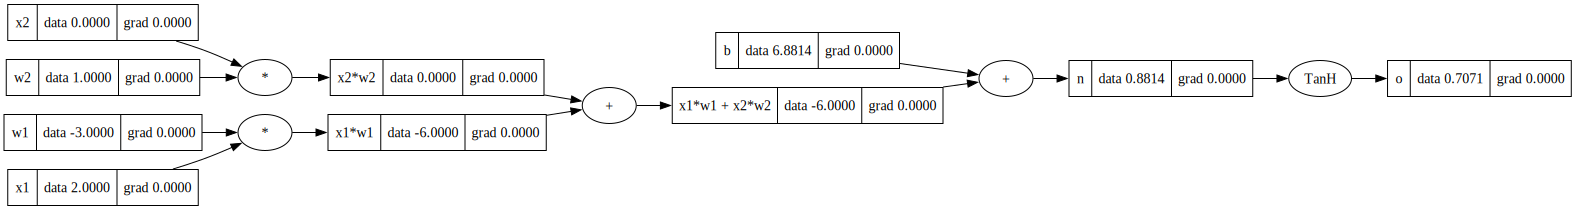

In [530]:
draw_dot(o)

In [531]:
o.backward()

In [532]:
# L.grad = 1.0

# f.grad = d.data
# d.grad = f.data

# c.grad = d.grad * 1.0
# e.grad = d.grad * 1.0

# a.grad = e.grad * b.data
# b.grad = e.grad * a.data

In [533]:
# def manual_derivative():
#     a = Node(2.0, label='a')
#     b = Node(-3.0, label='b')
#     c = Node(10.0, label='c')

#     e = a*b; e.label='e'
#     d = e + c; d.label='d'
#     f = Node(-2.0, label='f')
#     L = d*f; L.label='L'
#     L1 = L.data

#     h = 000.1
#     a = Node(2.0, label='a')
#     b = Node(-3.0, label='b')
#     c = Node(10.0, label='c')

#     e = a*b; e.label='e'
#     e.data+=h
#     d = e + c; d.label='d'
#     f = Node(-2.0, label='f')
#     L = d*f; L.label='L'
#     L2 = L.data

#     print((L2-L1)/h)

# manual_derivative()

In [534]:
import random

In [535]:
class Neuron:
    def __init__(self, inputs):
        self.w = []
        for _ in range(inputs):
            self.w.append(Node(random.uniform(-1, 1)))
        self.b = Node(random.uniform(-1,1))

        # print(self.w, self.b)

    def parameters(self):
        return self.w + [self.b]

    def __call__(self, x):
        total = Node(self.b.data)
        for wi, xi in zip(self.w, x):
            if type(xi) != Node:
                xi = Node(xi)
            # print('weight/input: ', wi, xi)
            activation = wi * xi
            total = total + activation
        output = total.tanh()

        # out = activation.tanh()
        return output
    


In [536]:
class Layer:
    def __init__(self, inputs, outputs):
        self.neurons = []
        for _ in range(outputs):
            self.neurons.append(Neuron(inputs))
    
    def __call__(self, x):
        output = []
        for neuron in self.neurons:
            # print('neuron: ', neuron.w, neuron.b)
            output.append(neuron(x))
        return output[0] if len(output) == 1 else output
    
    def parameters(self):
        parameters = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            parameters.extend(ps)
        return parameters

In [537]:
class MultiLayerPerceptron:
    def __init__(self, inputs, layers): 
        sz = [inputs] + layers
        self.layers = []
        for i in range(len(layers)):
            self.layers.append(Layer(sz[i], sz[i+1]))
    
    def __call__(self, x):
        for layer in self.layers:
            # print('layer: ', layer)
            x = layer(x)
        return x

    def parameters(self):
        parameters = []
        for layer in self.layers:
            ps = layer.parameters()
            parameters.extend(ps)
        return parameters

In [583]:
x = [2.0, 3.0, -1.0]
n = MultiLayerPerceptron(3, [4,4,1])
n(x)

Node(data=0.9077189089147277)

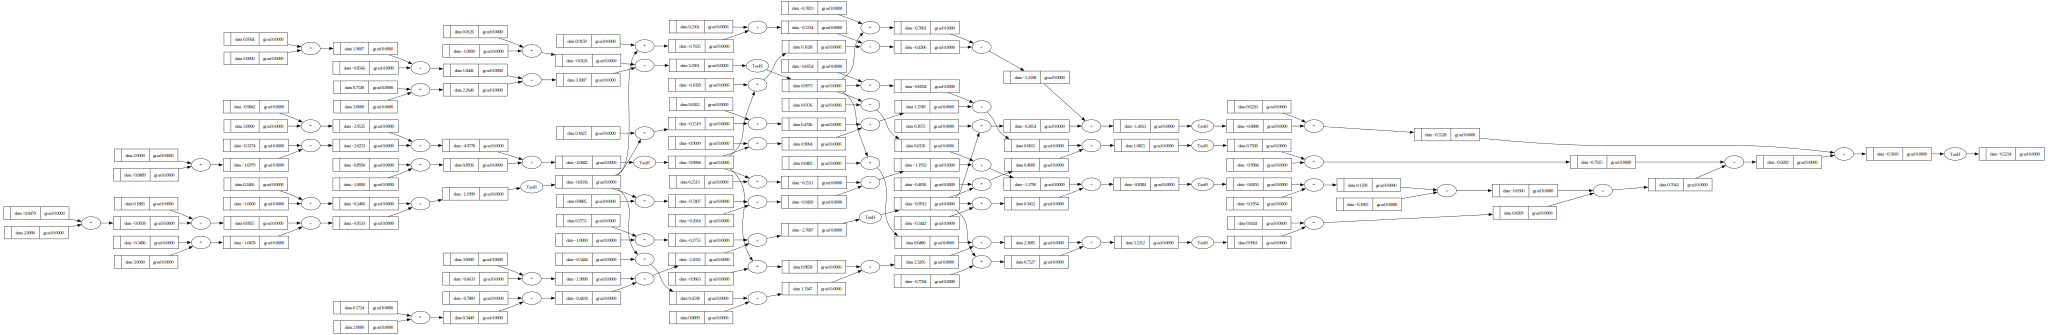

In [567]:
draw_dot(n(x))

In [584]:
xs = [[2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]

ys = [1.0, -1.0, -1.0, 1.0]

ypred = [n(x) for x in xs]
ypred

[Node(data=0.9077189089147277),
 Node(data=-0.022372850720333428),
 Node(data=0.4367434117745769),
 Node(data=0.9068846817124235)]

In [586]:
# ypred = [n(x) for x in xs]
# ypred

loss = Node(0.0)
for ygt, yout in zip(ys, ypred):
    loss += (yout - Node(ygt))**Node(2)

loss
# # loss = sum([(yout-Node(ygt))**2 ])
# # loss

Node(data=3.0371727365580243)

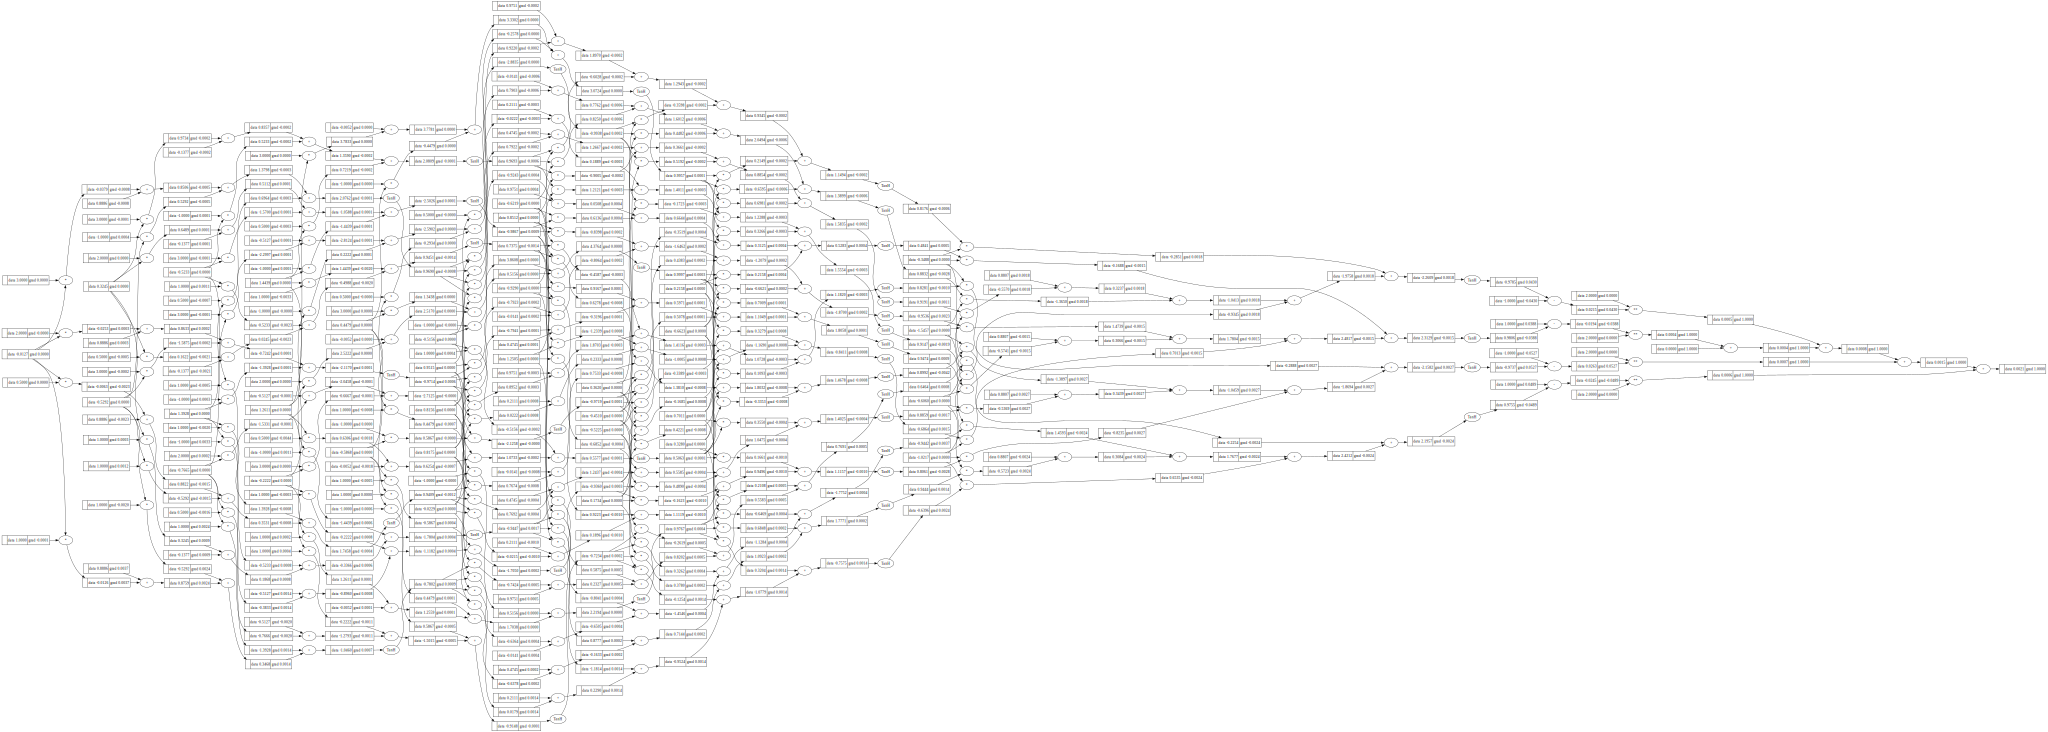

In [664]:
draw_dot(loss)

In [554]:
# loss.backward()

In [555]:
# n.layers[0].neurons[0].w[0].grad

In [556]:
# n.layers[0].neurons[0].w[0].data

In [557]:
# n.layers[0].neurons[0].w[0].data

In [558]:
# n.parameters()

In [559]:
# len(n.parameters())

In [560]:
# for parameter in n.parameters():
#     parameter.data += -0.01 * parameter.grad
#     # parameter.grad = 0.0

In [702]:
for k in range(2000):

    # Fordward
    ypred = [n(x) for x in xs]

    loss = Node(0.0)
    for ygt, yout in zip(ys, ypred):
        loss += (yout - Node(ygt))**Node(2)

    # Backward
    loss.backward()

    # Update
    for parameter in n.parameters():
        parameter.data += -0.1 * parameter.grad
        parameter.grad = 0.0
    
    print(f"Step {k}, loss: {loss.data}")


Step 0, loss: 8.849418213376882e-06
Step 1, loss: 8.849103092231567e-06
Step 2, loss: 8.848787993198643e-06
Step 3, loss: 8.84847291627424e-06
Step 4, loss: 8.848157861458833e-06
Step 5, loss: 8.84784282874726e-06
Step 6, loss: 8.847527818138522e-06
Step 7, loss: 8.847212829629866e-06
Step 8, loss: 8.846897863220008e-06
Step 9, loss: 8.84658291890514e-06
Step 10, loss: 8.846267996684274e-06
Step 11, loss: 8.845953096554325e-06
Step 12, loss: 8.84563821851266e-06
Step 13, loss: 8.845323362558776e-06
Step 14, loss: 8.845008528688771e-06
Step 15, loss: 8.844693716900146e-06
Step 16, loss: 8.844378927191342e-06
Step 17, loss: 8.844064159560154e-06
Step 18, loss: 8.843749414003976e-06
Step 19, loss: 8.843434690520726e-06
Step 20, loss: 8.843119989107698e-06
Step 21, loss: 8.842805309762178e-06
Step 22, loss: 8.842490652484217e-06
Step 23, loss: 8.842176017268272e-06
Step 24, loss: 8.841861404114516e-06
Step 25, loss: 8.841546813018641e-06
Step 26, loss: 8.84123224398152e-06
Step 27, loss: 8

In [703]:
ypred

[Node(data=0.9986813676237252),
 Node(data=-0.9986307465407452),
 Node(data=-0.9984820939866146),
 Node(data=0.9984692814231537)]